# Inititial processing

In [252]:
!pip install ecoindex
!pip install SQLAlchemy 
!pip install shap
!pip install tornado==4.5.3
!pip install bayesian_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.1 MB 38 kB/s 
     |████████████████████████████████| 16.9 MB 333 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=6.0.4, but you have tornado 4.5.3 which is incompatible.
bokeh 2.3.3 requires tornado>=5.1, but you have tornado 4.5.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [253]:

!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
from pprint import pprint
from ecoindex import get_ecoindex
from ecoindex.quantiles import quantiles_dom, quantiles_req, quantiles_size
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import time
import shap
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier 
from sklearn.ensemble import HistGradientBoostingRegressor
from pandas.io.formats.format import DataFrameRenderer
from sklearn.feature_selection import RFE
from bayes_opt import BayesianOptimization


In [255]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df


In [256]:
#Useful function if we want to display a specific number of row and columns
#Set to None if you want to display all 

pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns',None)

In [257]:
df = pd.read_csv('data_Urls-3.csv')
df = df.drop(labels = 'Unnamed: 0', axis = 1)
df  = swap_columns(df , 'domSize', 'idUrl')
df  = swap_columns(df , 'domSize', 'urlName')
df

,urlName,domSize,nbRequest,responsesSize,ecoIndex,grade,performance,accessibility,largestContentfulPaint,cumulativeLayoutShift,firstContentfulPaint,speedIndex,totalBlockingTime,interactive,addExpiresOrCacheControlHeaders,compressHttp,domainsNumber,dontResizeImageInBrowser,emptySrcTag,externalizeCss,externalizeJs,httpError,httpRequests,imageDownloadedNotDisplayed,jsValidate,maxCookiesLength,minifiedCss,minifiedJs,noCookieForStaticRessources,noRedirect,optimizeBitmapImages,optimizeSvg,plugins,printStyleSheet,socialNetworkButton,styleSheets,useETags,useStandardTypefaces,viewport,serverResponseTime,criticalRequestChains,mainthreadWorkBreakdown,bootupTime,usesRelPreload,fontDisplay,networkRtt,networkServerLatency,thirdPartySummary,thirdPartyFacades,lcpLazyLoaded,longTasks,nonCompositedAnimations,preloadLcpImage,idUrl,usesLongCacheTtl,usesResponsiveImages,offscreenImages,unminifiedCss,unminifiedJavascript,unusedCssRules,unusedJavascript,usesOptimizedImages,modernImageFormats,usesTextCompression,usesHttp2,efficientAnimatedContent,duplicatedJavascript,legacyJavascript,totalByteWeight,noDocumentWrite,redirects,layoutShiftElements,usesPassiveEventListeners
0,https://colab.research.google.com/?utm_source=...,19.0,66,3124,36,E,15,91,0,100,0,0,0,0,50,75,0,20,100,0,0,0,35,100,0,100,0,35,100,100,100,100,100,0,100,20,0,0,100,100,0,0.0,2.0,0,0,0,0,0,0,100,0,0,100,101beeeziail6q9kh4l,6.0,100.0,100.0,100.0,100.0,75.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,88.0,87.0,100,100.0,0,100
1,http://localhost:3001/,100.0,32,1734,73,B,27,92,6,100,66,30,2,7,0,75,0,100,100,75,100,100,65,100,0,100,100,0,100,75,100,100,100,0,100,75,0,0,100,100,0,80.0,89.0,0,100,0,0,100,0,0,0,0,100,ay919lcl6qihlok,7.0,100.0,100.0,100.0,43.0,88.0,34.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
2,http://www.aboutus.org,100.0,89,1287,57,C,46,77,76,100,47,27,10,14,0,35,0,35,100,50,0,100,20,100,0,100,0,0,100,0,100,100,100,0,100,35,0,0,0,100,0,100.0,100.0,0,100,0,0,0,0,0,0,0,0,101beeezpo0l6v314fa,64.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,79.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
3,http://above-inc.com,100.0,3,84,92,A,0,63,0,100,96,100,100,100,0,0,100,100,100,75,100,100,100,100,100,100,0,0,100,75,100,100,100,0,100,100,100,100,100,0,0,13.0,36.0,0,0,0,0,0,0,0,0,0,100,101beeezpo0l6v314fb,34.0,100.0,100.0,100.0,100.0,88.0,40.0,100.0,88.0,50.0,100.0,70.0,100.0,100.0,100.0,0,100.0,0,100
4,http://www.abpathfinder.com,57.0,120,1800,16,F,15,85,2,70,5,9,8,6,50,75,0,20,100,0,0,100,20,50,0,100,0,35,100,0,100,100,100,0,100,0,0,0,100,100,0,8.0,32.0,0,0,0,0,0,0,100,0,0,100,101beeezpo0l6v314fc,40.0,78.0,82.0,100.0,100.0,49.0,36.0,100.0,44.0,100.0,100.0,100.0,100.0,100.0,100.0,100,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,https://www.amazon.com/,40.0,366,3534,10,G,57,94,69,86,51,7,66,23,75,75,0,0,100,0,0,0,0,50,50,100,100,100,100,0,0,100,100,0,100,50,0,0,100,100,0,0.0,76.0,0,100,0,0,100,0,0,0,0,100,a8hbiy8lb1dfgdi,7.0,83.0,0.0,100.0,83.0,47.0,17.0,69.0,0.0,45.0,100.0,100.0,100.0,83.0,2.0,0,100.0,0,0
551,https://www.accenture.com/us-en,68.0,85,6666,23,F,34,98,1,96,3,0,62,0,75,50,50,0,100,0,0,100,35,25,0,100,0,0,100,75,0,100,100,0,100,35,75,100,100,100,0,11.0,63.0,0,0,0,0,0,0,100,0,0,100,a8hbiy8lb1dfgdj,99.0,48.0,100.0,100.0,100.0,100.0,41.0,88.0,41.0,88.0,100.0,100.0,100.0,100.0,99.0,0,100.0,0,0
552,https://ts-rhsso.tmma.paris.mdp/recrutement-is...,100.0,51,1018,67,C,49,98,0,99,0,0,100,41,0,0,75,100,100,100,0,50,35,100,0,100,0,0,100,75,100,100,100,0,100,20,75,0,100,0,0,75.0,100.0,0,0,0,0,0,0,0,0,0,0,a6p24lb216rq0,7.0,100.0,100.0,100.0,100.0,88.0,88.0,100.0,100.0,88.0,0.0,100.0,100.0,100.0,100.0,100,100.0,0,100
553,https://ts-rhsso.tmma.paris.mdp/recrutement-is...,97.0,58,979,58,C,49,93,0,99,20,9,100

In [258]:
#df = pd.read_csv('EcoIndex.csv')
#df = df.drop(columns = ['Unnamed: 0'])
#df

In [259]:
#save a copy
df_old = df

In [260]:
def normalize(df):
    df_to_reshap =['domSize',	'nbRequest','responsesSize']
    result = df.copy()
    for feature_name in df_to_reshap:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = ((df[feature_name] - min_value) / (max_value - min_value))*100
    return result

In [261]:
df = normalize(df)

In [262]:
df1 = df.iloc[:, 0:5]

df2 =  df.iloc[:, 14:]

df = pd.concat([df1, df2], axis = 1)

In [263]:
df = df.drop(columns = ['idUrl'])

## Visualisation

In [264]:
df.describe()

,domSize,nbRequest,responsesSize,ecoIndex,addExpiresOrCacheControlHeaders,compressHttp,domainsNumber,dontResizeImageInBrowser,emptySrcTag,externalizeCss,externalizeJs,httpError,httpRequests,imageDownloadedNotDisplayed,jsValidate,maxCookiesLength,minifiedCss,minifiedJs,noCookieForStaticRessources,noRedirect,optimizeBitmapImages,optimizeSvg,plugins,printStyleSheet,socialNetworkButton,styleSheets,useETags,useStandardTypefaces,viewport,serverResponseTime,criticalRequestChains,mainthreadWorkBreakdown,bootupTime,usesRelPreload,fontDisplay,networkRtt,networkServerLatency,thirdPartySummary,thirdPartyFacades,lcpLazyLoaded,longTasks,nonCompositedAnimations,preloadLcpImage,usesLongCacheTtl,usesResponsiveImages,offscreenImages,unminifiedCss,unminifiedJavascript,unusedCssRules,unusedJavascript,usesOptimizedImages,modernImageFormats,usesTextCompression,usesHttp2,efficientAnimatedContent,duplicatedJavascript,legacyJavascript,totalByteWeight,noDocumentWrite,redirects,layoutShiftElements,usesPassiveEventListeners
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0,555.000000,555.000000,555.0,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0,555.000000,555.000000,555.0,555.000000,555.0,555.0,555.000000,555.0,555.000000,555.0,555.0,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0,555.000000
mean,67.306306,14.324849,6.916565,48.596396,40.171171,63.396396,32.954955,38.369369,96.036036,38.810811,20.630631,82.792793,45.072072,74.189189,5.765766,100.0,14.846847,23.585586,100.0,60.747748,96.396396,88.036036,98.918919,5.045045,93.594595,48.855856,18.738739,34.864865,74.774775,67.747748,0.0,45.194595,62.848649,0.0,36.756757,0.0,0.0,39.099099,0.0,49.009009,0.0,0.0,82.421622,38.187387,69.864865,74.313514,86.445045,82.877477,68.731532,44.075676,71.789189,49.767568,80.145946,76.198198,87.084685,87.571171,85.796396,71.931532,66.306306,80.645045,0.0,53.873874
std,40.139421,13.540771,10.858256,27.043140,40.612609,25.279049,39.333432,43.928258,19.528711,41.449703,35.515271,32.859266,30.057019,34.636721,21.095859,0.0,34.485962,38.416647,0.0,38.411948,17.914397,30.021331,10.350478,21.907002,20.094712,38.295084,34.223388,47.460127,43.469705,46.786339,0.0,40.167137,37.236615,0.0,48.257772,0.0,0.0,48.841258,0.0,50.035276,0.0,0.0,36.848978,36.943476,40.198444,38.239494,32.270995,33.526154,33.845876,33.562185,39.697874,40.915803,36.140000,37.170118,32.983450,32.246678,32.211395,40.935306,47.308953,36.259670,0.0,49.894676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,25.000000,4.271845,1.303647,25.500000,0.000000,75.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.000000,20.000000,50.000000,0.000000,100.0,0.000000,0.000000,100.0,35.000000,100.000000,100.000000,100.000000,0.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,31.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,100.000000,2.500000,40.000000,47.000000,100.000000,87.500000,48.000000,17.500000,45.000000,0.000000,79.500000,51.000000,100.000000,100.000000,97.500000,32.000000,0.000000,100.000000,0.0,0.000000
50%,93.000000,11.262136,3.957815,47.000000,35.000000,75.000000,0.000000,20.000000,100.000000,20.000000,0.000000,100.000000,35.000000,100.000000,0.00

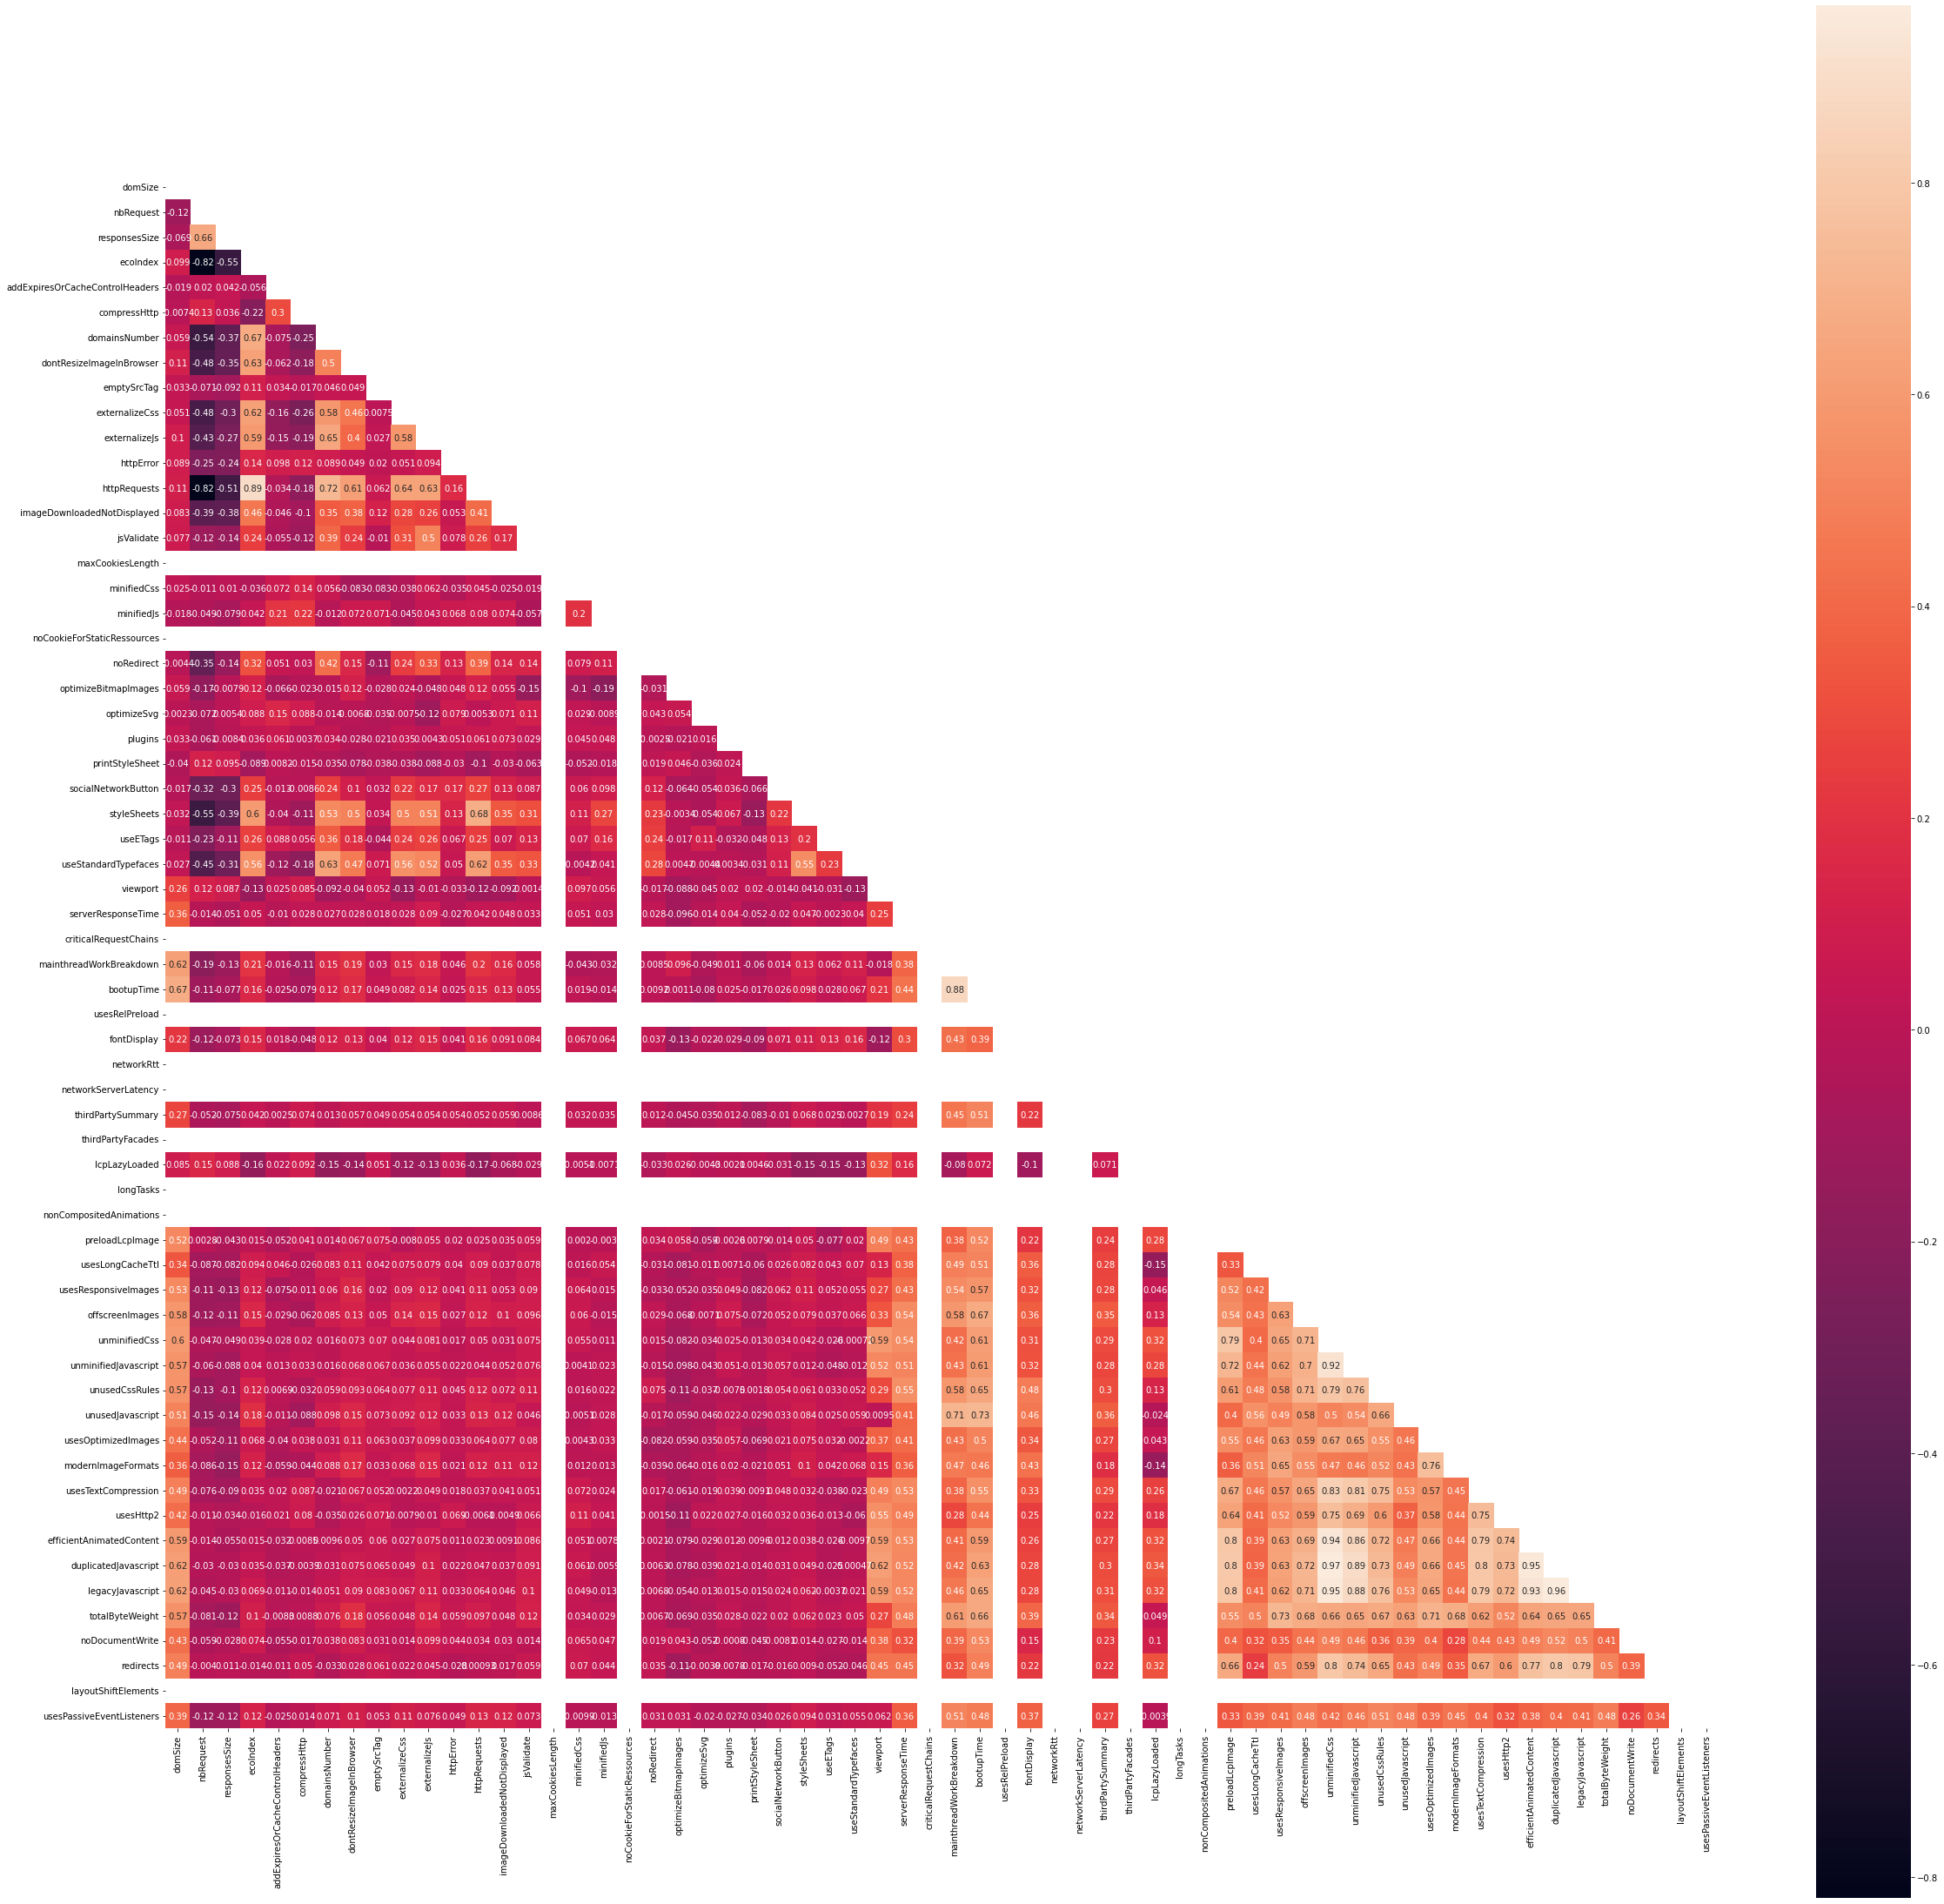

In [265]:
#This is the correlation matrix to display the correlation coefficient for the different variables

#pearson is the standard correlation coefficient
correlation = df.corr(method = 'pearson')

#plot the figure
plt.subplots(figsize = (40,40))

#mask upper triangle
masked = np.triu(np.ones_like(correlation, dtype=bool)) 

#correlation matrix with the coefficient
sns.heatmap(correlation,mask=masked,square = True, annot = True)

In [266]:
df

,urlName,domSize,nbRequest,responsesSize,ecoIndex,addExpiresOrCacheControlHeaders,compressHttp,domainsNumber,dontResizeImageInBrowser,emptySrcTag,externalizeCss,externalizeJs,httpError,httpRequests,imageDownloadedNotDisplayed,jsValidate,maxCookiesLength,minifiedCss,minifiedJs,noCookieForStaticRessources,noRedirect,optimizeBitmapImages,optimizeSvg,plugins,printStyleSheet,socialNetworkButton,styleSheets,useETags,useStandardTypefaces,viewport,serverResponseTime,criticalRequestChains,mainthreadWorkBreakdown,bootupTime,usesRelPreload,fontDisplay,networkRtt,networkServerLatency,thirdPartySummary,thirdPartyFacades,lcpLazyLoaded,longTasks,nonCompositedAnimations,preloadLcpImage,usesLongCacheTtl,usesResponsiveImages,offscreenImages,unminifiedCss,unminifiedJavascript,unusedCssRules,unusedJavascript,usesOptimizedImages,modernImageFormats,usesTextCompression,usesHttp2,efficientAnimatedContent,duplicatedJavascript,legacyJavascript,totalByteWeight,noDocumentWrite,redirects,layoutShiftElements,usesPassiveEventListeners
0,https://colab.research.google.com/?utm_source=...,19.0,12.621359,9.151897,36,50,75,0,20,100,0,0,0,35,100,0,100,0,35,100,100,100,100,100,0,100,20,0,0,100,100,0,0.0,2.0,0,0,0,0,0,0,100,0,0,100,6.0,100.0,100.0,100.0,100.0,75.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,88.0,87.0,100,100.0,0,100
1,http://localhost:3001/,100.0,6.019417,5.079830,73,0,75,0,100,100,75,100,100,65,100,0,100,100,0,100,75,100,100,100,0,100,75,0,0,100,100,0,80.0,89.0,0,100,0,0,100,0,0,0,0,100,7.0,100.0,100.0,100.0,43.0,88.0,34.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
2,http://www.aboutus.org,100.0,17.087379,3.770324,57,0,35,0,35,100,50,0,100,20,100,0,100,0,0,100,0,100,100,100,0,100,35,0,0,0,100,0,100.0,100.0,0,100,0,0,0,0,0,0,0,0,64.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,79.0,100.0,100.0,100.0,100.0,100.0,100.0,100,100.0,0,100
3,http://above-inc.com,100.0,0.388350,0.246082,92,0,0,100,100,100,75,100,100,100,100,100,100,0,0,100,75,100,100,100,0,100,100,100,100,100,0,0,13.0,36.0,0,0,0,0,0,0,0,0,0,100,34.0,100.0,100.0,100.0,100.0,88.0,40.0,100.0,88.0,50.0,100.0,70.0,100.0,100.0,100.0,0,100.0,0,100
4,http://www.abpathfinder.com,57.0,23.106796,5.273180,16,50,75,0,20,100,0,0,100,20,50,0,100,0,35,100,0,100,100,100,0,100,0,0,0,100,100,0,8.0,32.0,0,0,0,0,0,0,100,0,0,100,40.0,78.0,82.0,100.0,100.0,49.0,36.0,100.0,44.0,100.0,100.0,100.0,100.0,100.0,100.0,100,31.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,https://www.amazon.com/,40.0,70.873786,10.353010,10,75,75,0,0,100,0,0,0,0,50,50,100,100,100,100,0,0,100,100,0,100,50,0,0,100,100,0,0.0,76.0,0,100,0,0,100,0,0,0,0,100,7.0,83.0,0.0,100.0,83.0,47.0,17.0,69.0,0.0,45.0,100.0,100.0,100.0,83.0,2.0,0,100.0,0,0
551,https://www.accenture.com/us-en,68.0,16.310680,19.528343,23,75,50,50,0,100,0,0,100,35,25,0,100,0,0,100,75,0,100,100,0,100,35,75,100,100,100,0,11.0,63.0,0,0,0,0,0,0,100,0,0,100,99.0,48.0,100.0,100.0,100.0,100.0,41.0,88.0,41.0,88.0,100.0,100.0,100.0,100.0,99.0,0,100.0,0,0
552,https://ts-rhsso.tmma.paris.mdp/recrutement-is...,100.0,9.708738,2.982276,67,0,0,75,100,100,100,0,50,35,100,0,100,0,0,100,75,100,100,100,0,100,20,75,0,100,0,0,75.0,100.0,0,0,0,0,0,0,0,0,0,0,7.0,100.0,100.0,100.0,100.0,88.0,88.0,100.0,100.0,88.0,0.0,100.0,100.0,100.0,100.0,100,100.0,0,100
553,https://ts-rhsso.tmma.paris.mdp/recrutement-is...,97.0,11.067961,2.868024,58,0,0,75,100,100,100,0,0,35,100,0,100,0,0,100,75,100,100,100,0,100,0,75,0,100,100,0,76.0,100.0,0,0,0,0,0,0,0,0,0,0,6.0,100.0,100.0,100.0,100.0,75.0,67.0,100.0,100.0,67.0,49.0,100.0,100.0,100.0,100.0,100,100.0,0,100


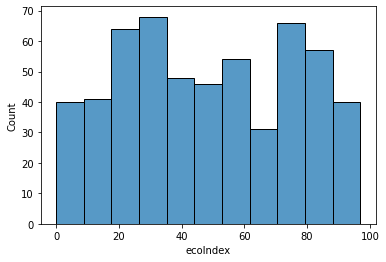

In [267]:
%matplotlib inline

sns.histplot(data=df, x='ecoIndex')


In [268]:

#sns.catplot(x = 'grade', kind = 'count', data = df)

#plt.show()

# EcoIndex Formulas

In [269]:
def get_quantile(quantiles, value):
   
    for i in range(1, len(quantiles) + 1):
        if value < quantiles[i]:
            return (i - 1 + (value - quantiles[i - 1]) / (quantiles[i] - quantiles[i - 1]))

    return len(quantiles) - 1
  


In [270]:
def get_score(dom: int, size: float, requests: int):
    q_dom = get_quantile(quantiles_dom, dom)
    q_size = get_quantile(quantiles_size, size)
    q_req = get_quantile(quantiles_req, requests)

    return round(100 - 5 * (3 * q_dom + 2 * q_req + q_size) / 6)


In [271]:
#Example
get_score(dom= 80, size= 8, requests= 1)


93

## Other Useful formulas

In [272]:
#function to count the number of time the value is greater than x
# This serves as an evaluation on our artificial model
def count2(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

In [273]:
#Fucntion to get the most important features
#Here, we consider that it is an important feature when its greater than 1, but that can be changed ! 

def get_feature_importance(importance_metric, X_train_number):

    feat = pd.Series(importance_metric*100, index=X_train_number.columns)
    feat_s = feat.sort_values(axis=0, ascending=False)
    feat = feat_s.index.tolist()
    
    features = []
    for values in feat:
        if feat_s[values] > 1 :
            features.append(values)
            
    
    return features

# EcoIndex

In [309]:
X = df.drop(columns = ["ecoIndex", 'nbRequest',	'responsesSize','domSize', 'httpRequests', 'urlName'])# "grade", 
y = df["ecoIndex"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


X_train,X_val,y_train,y_val = train_test_split(X_dev,y_dev,test_size=0.2,random_state=42)

In [310]:
X_dev_ecoIndex = X_test
y_test_EcoIndex = y_test

## Random Forest

In [275]:
params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 5)

gs1.fit(X_train, y_train)


y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selection:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_eco_index = gs1.best_estimator_.feature_importances_

model_EcoIndex = gs1 

Best Parameters:  {'max_depth': 40, 'n_estimators': 200}  

results before feature selection:
model score on training data : 0.9036769095415425
model score on testing data: 0.7115220369029887


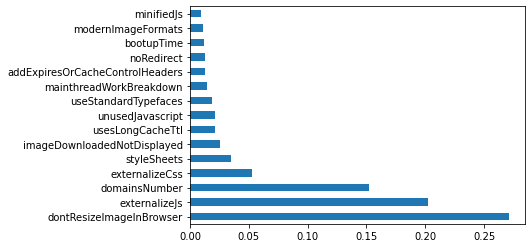

In [276]:
pd.Series(importances_eco_index, index=X_train.columns).nlargest(15).plot(kind='barh') 


In [277]:
importances_eco_index = get_feature_importance(importances_eco_index, X_train)
importances_eco_index

['dontResizeImageInBrowser',
 'externalizeJs',
 'domainsNumber',
 'externalizeCss',
 'styleSheets',
 'imageDownloadedNotDisplayed',
 'usesLongCacheTtl',
 'unusedJavascript',
 'useStandardTypefaces',
 'mainthreadWorkBreakdown',
 'addExpiresOrCacheControlHeaders',
 'noRedirect',
 'bootupTime',
 'modernImageFormats']

Permutation explainer: 112it [01:07,  1.40it/s]


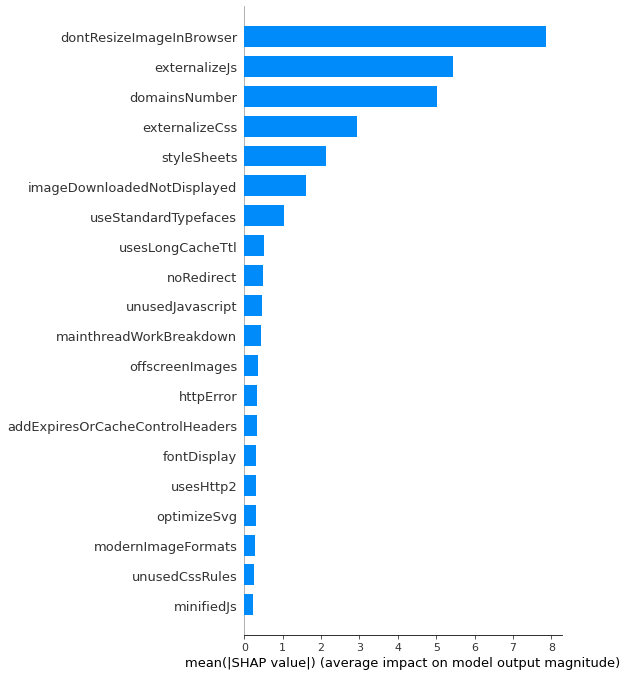

In [278]:
explainer = shap.Explainer(gs1.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## XGB

In [311]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.002],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)


print("results before feature selection:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_eco_index = gs2.best_estimator_.feature_importances_

model_EcoIndex = gs2


Time: 5.904375791549683 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 10, 'n_estimators': 40}
model performance on test dataset 0.767739772049372
results before feature selection:
model score on training data : 0.8238251018774313
model score on testing data: 0.767739772049372


In [312]:
##Bayesian Optimization

# Define the hyperparameters and their ranges
param_bounds = {
    'min_samples_split': (2, 10),  # lower bound is 2, upper bound is 10
    'learning_rate': (0.01, 0.1),  # lower bound is 0.01, upper bound is 0.1
    'n_estimators': (20, 70),      # lower bound is 20, upper bound is 70
}

# Define the objective function to be optimized
def objective(min_samples_split, learning_rate, n_estimators):
    model = GradientBoostingRegressor(
        min_samples_split=int(min_samples_split),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
    )
    model.fit(X_dev, y_dev)
    return model.score(X_test, y_test)

# Create a Bayesian optimization object
bo = BayesianOptimization(objective, param_bounds)

# Perform the Bayesian optimization
bo.maximize(n_iter=10)

# Print the results
print(f"Best hyperparameters: {bo.max['params']}")
print(f"Best performance: {bo.max['target']}")

# Train the final model using the best hyperparameters
best_params = bo.max['params']
final_model = GradientBoostingRegressor(
    min_samples_split=int(best_params['min_samples_split']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
)
final_model.fit(X_train, y_train)


|   iter    |  target   | learni... | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.6755    | 0.0304    | 2.376     | 55.19     |
| 2         | 0.7747    | 0.09357   | 7.296     | 56.42     |
| 3         | 0.6608    | 0.05214   | 3.996     | 29.52     |
| 4         | 0.6552    | 0.03748   | 5.886     | 39.21     |
| 5         | 0.777     | 0.07262   | 3.764     | 68.78     |
| 6         | 0.7577    | 0.07193   | 7.212     | 46.05     |
| 7         | 0.7756    | 0.09788   | 4.709     | 52.69     |
| 8         | 0.758     | 0.05276   | 5.785     | 66.01     |
| 9         | 0.7342    | 0.03934   | 9.713     | 67.65     |
| 10        | 0.7765    | 0.09178   | 5.602     | 54.46     |
| 11        | 0.7772    | 0.1       | 8.795     | 51.89     |
| 12        | 0.7113    | 0.1       | 10.0      | 20.0      |
| 13        | 0.7814    | 0.1       | 2.645     | 47.83     |
| 14        | 0.443     | 0.01      | 10.0      | 60.72     |
| 15    

GradientBoostingRegressor(n_estimators=47)

In [280]:
importances_eco_index = get_feature_importance(importances_eco_index, X_train)
importances_eco_index

['externalizeJs',
 'domainsNumber',
 'dontResizeImageInBrowser',
 'externalizeCss',
 'styleSheets',
 'imageDownloadedNotDisplayed',
 'useStandardTypefaces',
 'jsValidate',
 'noRedirect']

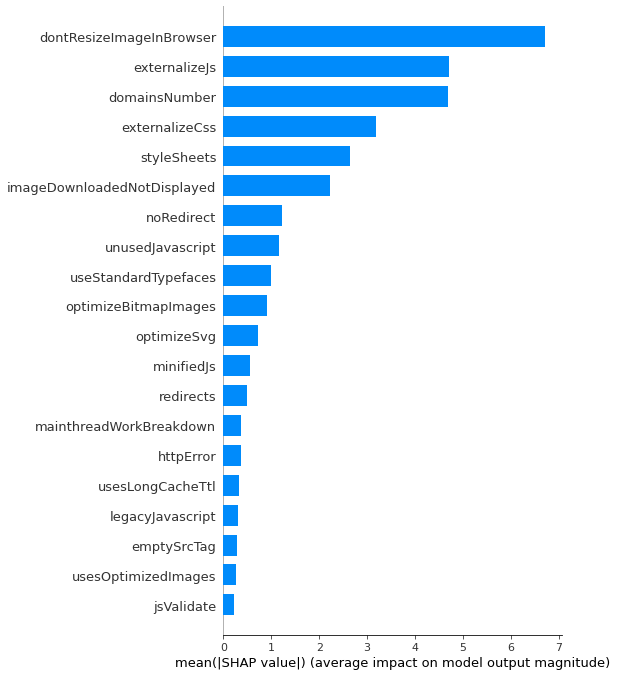

In [281]:
explainer = shap.Explainer(gs2.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

# Regression

## Nb Request

In [283]:
X = df.drop(columns = ["ecoIndex",	'nbRequest',	'responsesSize','domSize', 'httpRequests','domainsNumber','urlName' ])
y = df["nbRequest"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


X_train,X_val,y_train,y_val = train_test_split(X_dev,y_dev,test_size=0.2,random_state=42)

### Random Forest

In [284]:
start_time = time.time()

params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 5)

gs1.fit(X_train, y_train)

print("Time: {} seconds".format(time.time() - start_time))

y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selection:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_nbRequest = gs1.best_estimator_.feature_importances_


best_model = RandomForestRegressor(**gs1.best_params_)


rfe = RFE(best_model, n_features_to_select=15)

# Fit the model to the data
rfe.fit(X_train, y_train)

print(f'model score on training data : {rfe.score(X_dev,  y_dev)}')
print(f'model score on testing data: {rfe.score(X_test, y_test)}')

# Print the selected features
selected_features = list(X.columns[rfe.support_])
print(selected_features)

model_NbRequest = rfe

Time: 26.929860830307007 seconds
Best Parameters:  {'max_depth': 20, 'n_estimators': 200}  

results before feature selection:
model score on training data : 0.8786004363668658
model score on testing data: 0.4850204398990702
model score on training data : 0.8771802539358323
model score on testing data: 0.45686455005690574
['addExpiresOrCacheControlHeaders', 'dontResizeImageInBrowser', 'externalizeCss', 'externalizeJs', 'httpError', 'imageDownloadedNotDisplayed', 'noRedirect', 'optimizeBitmapImages', 'socialNetworkButton', 'styleSheets', 'useStandardTypefaces', 'bootupTime', 'usesLongCacheTtl', 'unusedCssRules', 'unusedJavascript']


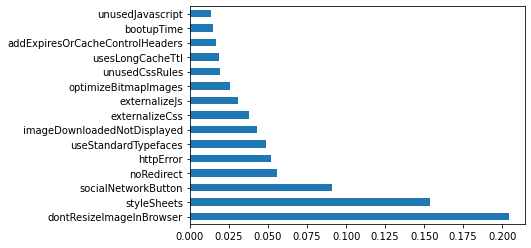

In [285]:
# Model Feature Importance

pd.Series(importances_nbRequest, index=X_train.columns).nlargest(15).plot(kind='barh') 

In [286]:
importances_nbRequest = get_feature_importance(importances_nbRequest, X_train)
importances_nbRequest

['dontResizeImageInBrowser',
 'styleSheets',
 'socialNetworkButton',
 'noRedirect',
 'httpError',
 'useStandardTypefaces',
 'imageDownloadedNotDisplayed',
 'externalizeCss',
 'externalizeJs',
 'optimizeBitmapImages',
 'unusedCssRules',
 'usesLongCacheTtl',
 'addExpiresOrCacheControlHeaders',
 'bootupTime',
 'unusedJavascript',
 'usesResponsiveImages',
 'mainthreadWorkBreakdown']

Permutation explainer: 112it [01:00,  1.53it/s]


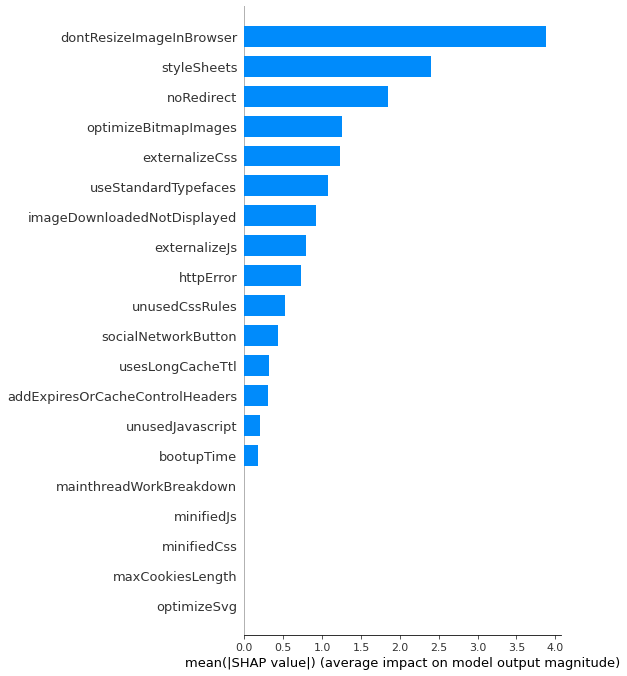

In [287]:
## SHAP feature Importance

explainer = shap.Explainer(rfe.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

### XG boost

In [288]:
from sklearn.ensemble import GradientBoostingRegressor

In [289]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.002],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)



print("results before feature selection:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_nbRequest = gs2.best_estimator_.feature_importances_




Time: 6.548116445541382 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 50, 'n_estimators': 40}
model performance on test dataset 0.48233376796927596
results before feature selection:
model score on training data : 0.7858583608226694
model score on testing data: 0.48233376796927596


In [290]:
importances_nbRequest = get_feature_importance(importances_nbRequest, X_train)
importances_nbRequest

['styleSheets',
 'dontResizeImageInBrowser',
 'socialNetworkButton',
 'noRedirect',
 'imageDownloadedNotDisplayed',
 'optimizeBitmapImages',
 'externalizeJs',
 'httpError',
 'externalizeCss',
 'useStandardTypefaces',
 'unusedCssRules',
 'optimizeSvg',
 'lcpLazyLoaded']

In [291]:
explainer = shap.Explainer(gs2.predict, X_test)

shap_values = explainer(X_test)

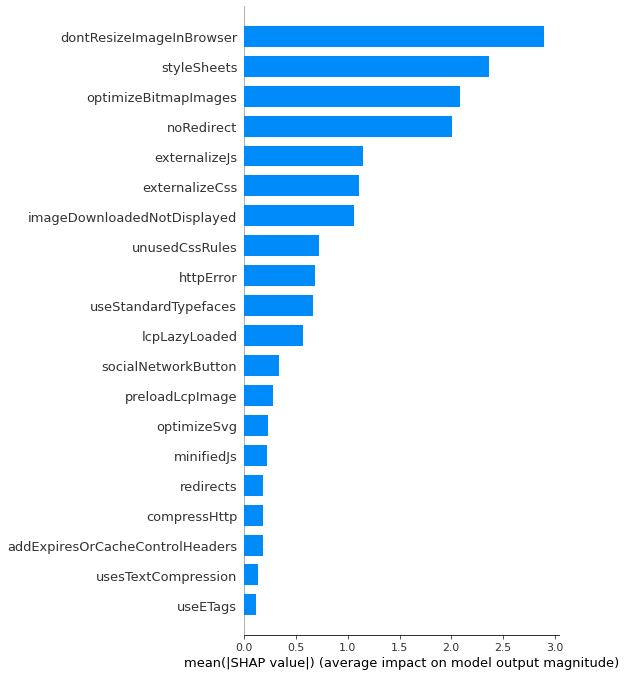

In [292]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## DomSize

In [293]:
X = df.drop(columns = ["ecoIndex", 'nbRequest',	'responsesSize','domSize', 'httpRequests', 'urlName'])
y = df["domSize"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


X_train,X_val,y_train,y_val = train_test_split(X_dev,y_dev,test_size=0.2,random_state=42)

### Random Forest

In [294]:
start_time = time.time()

params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 10)

gs1.fit(X_train, y_train)


print("Time: {} seconds".format(time.time() - start_time))

y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selectio:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_DomSize = gs1.best_estimator_.feature_importances_


best_model = RandomForestRegressor(**gs1.best_params_)


rfe = RFE(best_model, n_features_to_select=15)

# Fit the model to the data
rfe.fit(X_train, y_train)

print("results after feature selection:")

print(f'model score on training data : {rfe.score(X_dev,  y_dev)}')
print(f'model score on testing data: {rfe.score(X_test, y_test)}')

# Print the selected features
selected_features = list(X.columns[rfe.support_])
print(selected_features)

model_Domsize = rfe

Time: 47.351383686065674 seconds
Best Parameters:  {'max_depth': 40, 'n_estimators': 200}  

results before feature selectio:
model score on training data : 0.8306978866749006
model score on testing data: 0.5823983434985563
results after feature selection:
model score on training data : 0.8253833920345196
model score on testing data: 0.5728174238346622
['addExpiresOrCacheControlHeaders', 'externalizeCss', 'styleSheets', 'mainthreadWorkBreakdown', 'bootupTime', 'usesLongCacheTtl', 'usesResponsiveImages', 'unminifiedJavascript', 'unusedCssRules', 'unusedJavascript', 'usesOptimizedImages', 'modernImageFormats', 'usesHttp2', 'totalByteWeight', 'redirects']


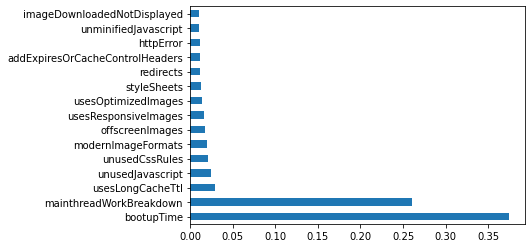

In [295]:
## Model Feature Importance

pd.Series(importances_DomSize, index=X.columns).nlargest(15).plot(kind='barh') 

In [296]:
importances_DomSize = get_feature_importance(importances_DomSize, X_train)


Permutation explainer: 112it [00:59,  1.53it/s]


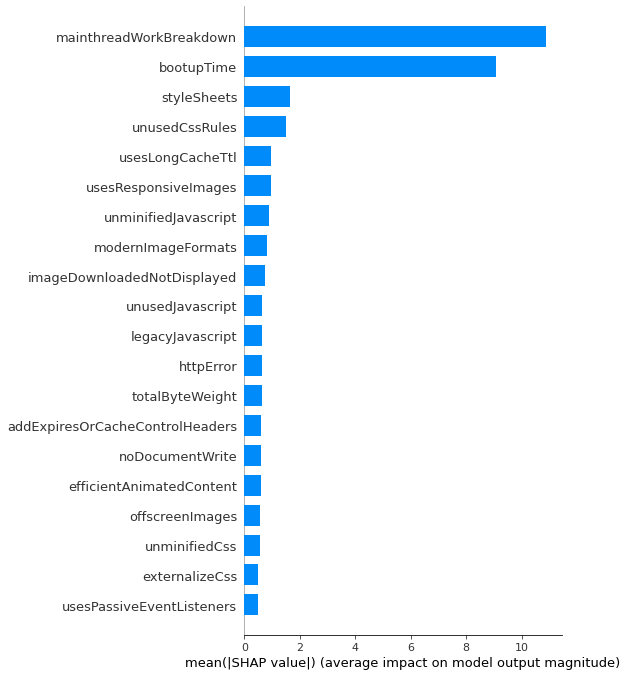

In [297]:
## SHAP EXPLAINER

explainer = shap.Explainer(gs1.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

### XGB

In [298]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,0.002],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 10)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)



print("results before feature selectio:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_nbRequest = gs2.best_estimator_.feature_importances_


Time: 12.102078914642334 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 10, 'n_estimators': 20}
model performance on test dataset 0.5412749671853703
results before feature selectio:
model score on training data : 0.8306978866749006
model score on testing data: 0.5823983434985563


## responsesSize

In [299]:
X = df.drop(columns = ["ecoIndex", 'nbRequest',	'responsesSize','domSize', 'httpRequests', 'urlName'])
y = df["responsesSize"]


# split the data into developing and testing sets
X_dev,X_test,y_dev,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


#X_train,X_val,y_train,y_val = train_test_split(X_dev,y_dev,test_size=0.2,random_state=42)

### Random Forest

In [300]:
start_time = time.time()

params = {'n_estimators' : [10,50, 100, 200],
          'max_depth' : [10, 20, 40,50]}


rf = RandomForestRegressor(random_state=42)

gs1 = GridSearchCV(rf, params, cv = 10)

gs1.fit(X_train, y_train)


print("Time: {} seconds".format(time.time() - start_time))

y_pred = gs1.predict(X_test)

print ('Best Parameters: ', gs1.best_params_, ' \n')

print("results before feature selection:")
print(f'model score on training data : {gs1.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs1.score(X_test, y_test)}')

importances_ResponseSize = gs1.best_estimator_.feature_importances_


best_model = RandomForestRegressor(**gs1.best_params_)


rfe = RFE(best_model, n_features_to_select=15)

# Fit the model to the data
rfe.fit(X_train, y_train)
print("results after feature selection:")

print(f'model score on training data : {rfe.score(X_dev,  y_dev)}')
print(f'model score on testing data: {rfe.score(X_test, y_test)}')

# Print the selected features
selected_features = list(X.columns[rfe.support_])
print(selected_features)

model_responseSize = rfe

Time: 48.46588754653931 seconds
Best Parameters:  {'max_depth': 40, 'n_estimators': 200}  

results before feature selection:
model score on training data : -37.11168410320096
model score on testing data: -66.46403540109475
results after feature selection:
model score on training data : -37.39378619184557
model score on testing data: -67.76670915452215
['addExpiresOrCacheControlHeaders', 'externalizeCss', 'styleSheets', 'mainthreadWorkBreakdown', 'bootupTime', 'usesLongCacheTtl', 'usesResponsiveImages', 'offscreenImages', 'unminifiedJavascript', 'unusedCssRules', 'unusedJavascript', 'usesOptimizedImages', 'modernImageFormats', 'totalByteWeight', 'redirects']


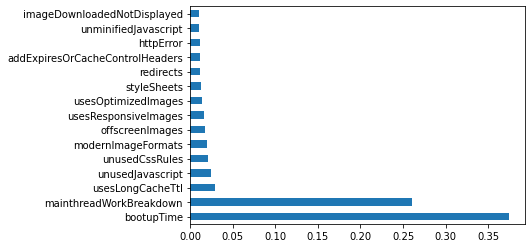

In [301]:
## Model Feature Importance

pd.Series(importances_ResponseSize, index=X.columns).nlargest(15).plot(kind='barh') 

In [302]:
importances_ResponseSize = get_feature_importance(importances_nbRequest, X_train)
importances_ResponseSize

['mainthreadWorkBreakdown',
 'bootupTime',
 'unminifiedJavascript',
 'usesResponsiveImages',
 'totalByteWeight',
 'modernImageFormats',
 'unusedCssRules',
 'fontDisplay',
 'usesOptimizedImages',
 'redirects']

### XGB

In [303]:

start_time = time.time()

params = {'min_samples_split' : [2,10,50],
          'learning_rate' : [0.1,7,100],
          'n_estimators' : [20, 40, 70]}

gs2 = GridSearchCV(GradientBoostingRegressor(), params, cv = 5)

gs2.fit(X_dev, y_dev)

print("Time: {} seconds".format(time.time() - start_time))

print("best parameters are", gs2.best_params_)

print("model performance on test dataset", gs2.score(X_test, y_test))

y_pred = gs2.predict(X_test)



print("results before feature selectio:")
print(f'model score on training data : {gs2.score(X_dev,  y_dev)}')
print(f'model score on testing data: {gs2.score(X_test, y_test)}')

importances_responseSize = gs2.best_estimator_.feature_importances_


Time: 8.750070333480835 seconds
best parameters are {'learning_rate': 0.1, 'min_samples_split': 50, 'n_estimators': 20}
model performance on test dataset 0.04520759272643027
results before feature selectio:
model score on training data : 0.5234960382092637
model score on testing data: 0.04520759272643027


overflow encountered in square


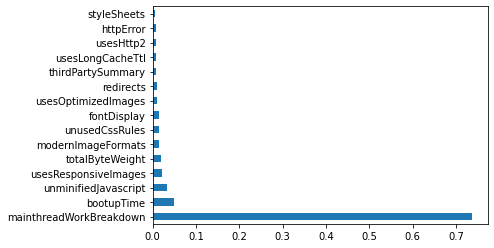

In [304]:
## Model Feature Importance

pd.Series(importances_nbRequest, index=X.columns).nlargest(15).plot(kind='barh') 

Permutation explainer: 112it [01:00,  1.53it/s]


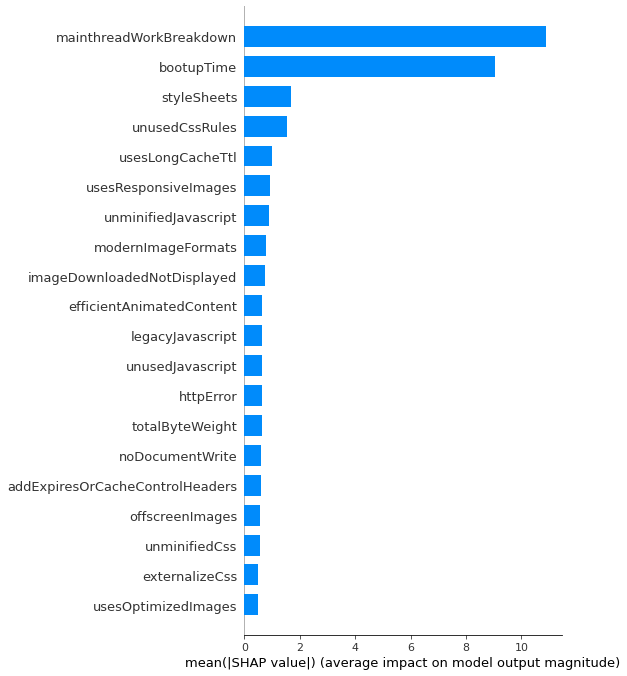

In [305]:
## SHAP EXPLAINER

explainer = shap.Explainer(gs1.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

# Recommendations Applications

In [308]:
y

,responsesSize
231,10.496558
374,4.406035
55,12.430057
381,2.038963
70,3.433426
...,...
11,3.292808
281,3.278160
22,0.732386
375,1.901274


In [313]:
y = pd.DataFrame(y_test)
df_analysis = pd.concat([X_test,y], axis = 1)

#model_EcoIndex

df_old = X_test
df_new = df_analysis.drop(columns = ['ecoIndex'])

In [314]:
 for index, row in df_analysis.iterrows():

      grade = row['ecoIndex']

      if grade < 50 :
  
        if df_new.at[index, 'dontResizeImageInBrowser'] < 50:
        
            df_new.at[index, 'dontResizeImageInBrowser'] = 100

        if df_new.at[index, 'externalizeJs'] < 50:
        
            df_new.at[index, 'externalizeJs'] = 100

        if df_new.at[index, 'styleSheets'] < 50:
        
            df_new.at[index, 'styleSheets'] = 100

### Predict the New EcoIndex with the Regressor EcoIndex

In [315]:

model_EcoIndex = final_model
# predict the Eco-Index

#old
pred_old = model_EcoIndex.predict(df_old)
#plot the distribution of EcoIndex

#new
pred_new = model_EcoIndex.predict(df_new)
#plot the distribution of Grades



In [319]:
d = {'Old EcoIndex': pred_old, "Current EcoIndex": pred_new}
dataset  = pd.DataFrame(d)
dataset

,Old EcoIndex,Current EcoIndex
0,25.317599,49.027012
1,31.694651,58.810924
2,40.954145,53.998363
3,56.548501,56.548501
4,58.640150,71.052350
...,...,...
106,35.266098,35.266098
107,45.104729,67.895349
108,85.794758,85.794758
109,62.399995,62.399995


Text(0.5, 0, 'EcoIndex')

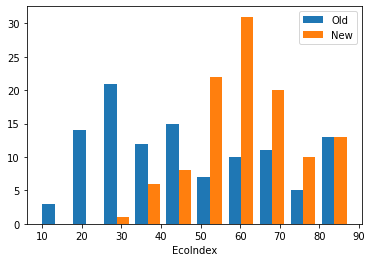

In [320]:
%matplotlib inline
plt.hist([pred_old, pred_new], label=['Old', 'New'])
plt.legend()

plt.xlabel('EcoIndex')


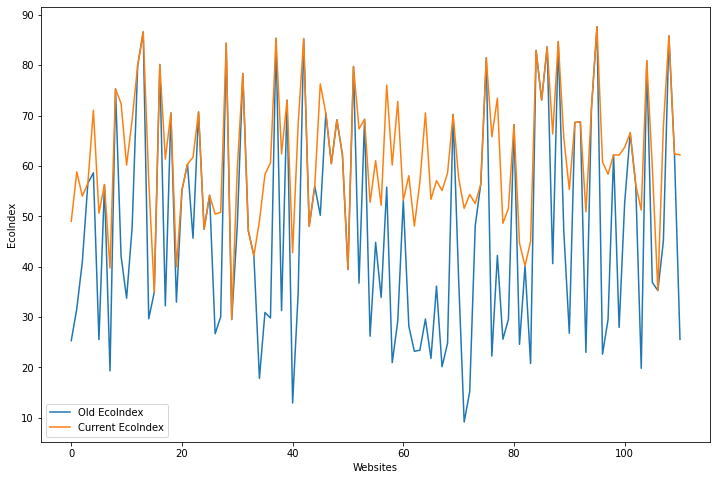

In [322]:
plt.figure(figsize=(12,8)) 
y = [i for i in range(len(df_old))]


plt.plot(y, pred_old, label = "Old EcoIndex")
plt.plot(y, pred_new, label = "Current EcoIndex")

plt.ylabel('EcoIndex')
plt.xlabel('Websites')

plt.legend()
plt.show()